# Regularizing regression: LASSO and Ridge


## Overview

In this section, we will begin discussing generalizations of the usual least-squares linear regression problem. In particular, we will introduce here the concept of _regularization_, specifically as it applies to two methods used frequently with linear regression: LASSO and Ridge Regression. Before explaining these methods, let's give a bit of motivation for why they might be useful. Recall the usual least-squares problem and solution:

$$
\boldsymbol{\beta}_{OLS} = (\boldsymbol{X^\top X})^{-1}\boldsymbol{X^\top y} = \arg\min_{\boldsymbol{\beta}}\|\boldsymbol{X\beta} - \boldsymbol{y}\|_2^2.
$$

As we've discussed in a [previous section](../basic_linear_regression/more_least_squares.md), a point of complication that can arise when using this solution is in computing the inverse of the matrix $\boldsymbol{X^\top X}$. In particular, there are two types of issues that may arise when doing this:

1. If $n<p$ (i.e. the number of examples is less than the number of features), then the matrix $\boldsymbol{X^\top X}$ is not invertible, and so $\hat{\boldsymbol{\beta}}_{OLS}$ _doesn't even exist_.
2. Even if $\boldsymbol{X^\top X}$ _does_ exist, the inverse may be particularly poorly behaved. This will happen, for example, if one of the columns of $\boldsymbol{X}$ is very close to being a linear combination of some of the other columns.

In case 1, we will always need to find a different way to fit a linear regression model (for example, using the Moore-Penrose solution instead). Let's examine what might happen in case 2 a bit more closely. If the matrix $\boldsymbol{X^\top X}$ is poorly behaved, in the way described above, then what will generally occur is that its inverse $(\boldsymbol{X^\top X})^{-1}$ will typically contain many very large values. This has a few consequences. First, it will tend to make the coefficients in $\hat{\boldsymbol{\beta}}$ also very large. Moreover, recall that under the Gaussian model for linear regression, the variance of a coefficient $\hat{\beta}_j$ is given by $\sigma^2 (\boldsymbol{X^\top X})^{-1}_{jj}$. Thus, this same issue will cause the variance around the coefficients to become very large.

Let's illustrate this with an example. In the following cell, we construct a data matrix $\boldsymbol{X}$ that is intentionally poorly conditioned. We construct this dataset as follows:
1. We generate a random matrix $\boldsymbol{X}_0 \in \mathbb{R}^{n\times (p-1)}$.
2. We create a new column $\boldsymbol{x}_p = \sum_{j=1}^{p-1} \boldsymbol{x}_j + \boldsymbol{\xi}$, and set $\boldsymbol{X} = [\boldsymbol{X}_0, \boldsymbol{x}_p]$. This matrix is _almost_ not full rank, which will suffice to make the inverse of $\boldsymbol{X^\top X}$ be very "bad".
3. Finally, we generate the responses $\boldsymbol{y}$ as usual using a linear model $\boldsymbol{y} = \boldsymbol{X\beta}_\star + \boldsymbol{\varepsilon}$.

In [1]:
import numpy as np
np.random.seed(42)

n, p = 50, 5
X0 = np.random.normal(size=(n,p-1))
xp = np.sum(X0, axis=1).reshape(n,1) + 1e-8*np.random.normal(size=(n,1))
X = np.hstack((X0, xp))
beta_star = np.random.normal(size=p)
y = np.dot(X, beta_star) + 2**np.random.normal(size=n)

Now let's actually fit the regression model and inspect the results. We'll do this using the `statsmodels` package.

In [2]:
import statsmodels.api as sm

results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.774
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                              30.78
Date:                Thu, 13 Oct 2022   Prob (F-statistic):                    1.82e-13
Time:                        22:58:20   Log-Likelihood:                         -86.459
No. Observations:                  50   AIC:                                      182.9
Df Residuals:                      45   BIC:                                      192.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.187e+07      2e+07     -0.594      0.556   -5.21e+07    2.84e+07
x2         -1.187e+07      2e+07     -0.594      0.556   -5.21e+07    2.84e+07
x3         -1.187e+07      2e+07     -0.594      0.556   -5.21e+07    2.84e+07
x4         -1.187e+07      2e+07     -0.594      0.556   -5.21e+07    2.84e+07
x5          1.187e+07      2e+07      0.594      0.556   -2.84e+07    5.21e+07
==============================================================================
Omnibus:                       15.132   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.117
Skew:                           0.963   Prob(JB):                     1.58e-05
Kurtosis:                       5.628   Cond. No.                     4.75e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.03e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

There are a few interesting things to note in these outputs. First, the regression coefficients are extremely large -- very far away from the true $\hat{\boldsymbol{\beta}}_\star$ that we drew from a normal distribution. Moreover, the standard deviations of the coefficients are also massive, again due to large values on the diagonal of $(\boldsymbol{X^\top X})^{-1}$. In general, the message is that we can't trust the results in situations like this one. While this particular example is made up, such situations also arise in practice. For example, datasets in genetics frequently contain very high-dimensional datasets that lead to poorly-conditioned data matrices.

So what can we do in these situations? One option is to _regularization_ to reduce the variance in our estimates of the coefficients. There are many forms of regularization, but we will focus on so-called shrinkage methods. Such methods change the least-squares objective by adding a term which penalizes large coefficients. There are two common ways of doing this. In *Ridge Regression*, we add a penalty term using the squared $2$-norm:

$$
\min_{\boldsymbol{\beta}} \|\boldsymbol{X\beta} - \boldsymbol{y}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_2^2.
$$

In LASSO, we penalize the size of the coefficients measured according to the $1$-norm:

$$
\min_{\boldsymbol{\beta}} \|\boldsymbol{X\beta} - \boldsymbol{y}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_1.
$$

(Recall that the $1$-norm of a vector $\boldsymbol{v}$ is the sum of its absolute values: $\|\boldsymbol{v}\|_1 = \sum_{j=1}^p |v_j|$.)

In general, adding penalty terms of this form will force the solution to be "smaller" in size. The constant $\lambda$ (called the "regularization parameter") controls how much this size is penalized: larger $\lambda$ will result in smaller weights. In the next sections, we discuss Ridge and LASSO in more detail, and will see how changing the regularization parameter $\lambda$ effects the solutions obtained from these methods.

## Ridge Regression

For a given regularization parameter $\lambda$, the Ridge solution $\hat{\boldsymbol{\beta}}_{RR}(\lambda)$ is defined as the solution to the following problem:

$$
\begin{align*}
\hat{\boldsymbol{\beta}}_{RR}(\lambda) &= \arg\min_{\boldsymbol{\beta}} \|\boldsymbol{X\beta} - \boldsymbol{y}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_2^2 \\
&= \arg\min_{\boldsymbol{\beta}} \left\{\boldsymbol{\beta}^\top (\boldsymbol{X^\top X} + \lambda \boldsymbol{I})\boldsymbol{\beta}  - 2\boldsymbol{\beta^\top \boldsymbol{X}^\top y} + \boldsymbol{y^\top y}\right\}
\end{align*}
$$

Using a bit of calculus (similar to what we did for OLS), we can obtain a closed formula for $\hat{\boldsymbol{\beta}}_{RR}(\lambda)$:

$$
\hat{\boldsymbol{\beta}}_{RR}(\lambda) = (\boldsymbol{X^\top X} + \lambda I)^{-1}\boldsymbol{X^\top y}.
$$


As we have claimed, the Ridge solution will make the coefficients of smaller as $\lambda$ increases. Let's check that this is indeed the case on our synthetic example defined above, and see that reasonable choices of $\lambda$ result in much better behaved solutions. First, we'll define a simple python function which computes the Ridge Regression solution.

In [3]:
def fit_RR(X, y, lamb):
    return np.dot(np.linalg.inv(X.T@X + lamb*np.eye(X.shape[1])), np.dot(X.T, y))

Just to get a sense of the coefficients that we get, let's try fitting the model to our dataset with $\lambda = 1/2$.

In [4]:
fit_RR(X, y, lamb=0.5)

array([-2.41527568, -0.06501881,  1.15409358,  0.56122125, -0.76497953])

Let's compare these to the "true" coefficients $\boldsymbol{\beta}_\star$ that we used to generate the labels:

In [5]:
beta_star

array([-1.26088395,  0.91786195,  2.1221562 ,  1.03246526, -1.51936997])

We can see that this solution, choosing $\lambda$ arbitrarily, already improves performance substantially. To visualize exactly what happens to each of the coefficients as we increase the size of $\lambda$, we can plot the entire trajectory of $\hat{\boldsymbol{\beta}}_{RR}(\lambda)$ as a function of $\lambda$. We do this in the cell below across a grid of $\lambda$ values, along with the values of $\hat{\boldsymbol{\beta}}_\star$ for comparison. We also plot the values of $\|\boldsymbol{\beta}_\star - \hat{\boldsymbol{\beta}}_{RR}(\lambda)\|_2^2$ as a function of $\lambda$ so we can see how close the solution gets to the true solution $\boldsymbol{\beta}_\star$.

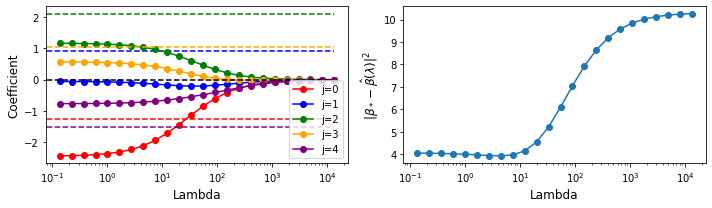

In [6]:
lamb_range = np.exp(np.arange(-2, 10, 0.5))

RR_solutions = []
for lamb in lamb_range:
    beta_hat_RR_curr = fit_RR(X, y, lamb)
    RR_solutions.append(beta_hat_RR_curr)
RR_solutions = np.array(RR_solutions)
errors = [np.linalg.norm(sol-beta_star)**2 for sol in RR_solutions]

import matplotlib.pyplot as plt

colors = ["red", "blue", "green", "orange", "purple"]

fig, axs = plt.subplots(1, 2, figsize=(10,3))
axs = axs.flatten()
for j in range(RR_solutions.shape[1]):
    axs[0].plot(lamb_range, RR_solutions[:, j], color=colors[j], marker='o', label=f'j={j}')
    axs[0].hlines(beta_star[j], 0, np.max(lamb_range), color=colors[j], linestyle='--')

axs[0].hlines(0, 0, np.max(lamb_range), color="black", linestyle='--')
axs[0].set_xlabel("Lambda", fontsize=12)
axs[0].set_ylabel("Coefficient", fontsize=12)
axs[0].legend()
axs[0].set_xscale('log')

axs[1].plot(lamb_range, errors, marker='o')
axs[1].set_xlabel("Lambda", fontsize=12)
axs[1].set_ylabel(r"$\|\beta_* - \hat{\beta}(\lambda)\|^2$", fontsize=12)
axs[1].set_xscale('log')
plt.tight_layout()
plt.show()

From these plots, we can make a few important observations. First, the solutions are all much better in than the OLS solution, as seen in the plot on the right. For small $\lambda$, the error $\|\boldsymbol{\beta}_\star - \hat{\boldsymbol{\beta}}_{RR}(\lambda)\|_2^2$ is actually reasonably small -- and in fact reaches a minimum at the best possible regularization parameter $\lambda_*$. As $\lambda$ increases, however, we start to overcorrect, and the coefficients become closer and closer to zero, and the error correspondingly starts to increase. In general, this is a tradeoff that will always exist, and requires careful choice of the regularization parameter $\lambda$. Next, we discuss how this tradeoff comes about.

To understand the performance of the Ridge Regression solution, and how it performs as a function of $\lambda$, we consider the bias-variance decomposition:

$$
\text{MSE}(\hat{\boldsymbol{\beta}}_{RR}(\lambda)) = \text{Bias}^2(\hat{\boldsymbol{\beta}}_{RR}(\lambda)) + \text{Var}(\hat{\boldsymbol{\beta}}_{RR}(\lambda))
$$

Intuitively, higher $\lambda$ should make the variance of $\hat{\boldsymbol{\beta}}_{RR}(\lambda)$ smaller, while making the bias bigger (since it is biasing the estimator toward zero). Fortunately, both the bias and the variance have closed form solutions for Ridge Regression.

Similar to OLS regression, where $\text{Var}(\hat{\boldsymbol{\beta}}_{OLS}) = \sigma^2 (\boldsymbol{X^\top X})^{-1}$, the variance of the Ridge Regression solution is given by (assuming the errors are normally distribution):

$$
\text{Var}(\hat{\boldsymbol{\beta}}_{RR}(\lambda)) = \sigma^2 (\boldsymbol{X^\top X} + \lambda \boldsymbol{I})^{-1}\boldsymbol{X^\top X}(\boldsymbol{X^\top X} + \lambda \boldsymbol{I})^{-1}.
$$

The bias is given by

$$
\text{Bias}(\hat{\boldsymbol{\beta}}_{RR}(\lambda)) = ((\boldsymbol{X^\top X} + \lambda \boldsymbol{I})^{-1}\boldsymbol{X^\top X} - \boldsymbol{I})\boldsymbol{\beta}_\star
$$

Let's plot these for our example (note that for the variance, we plot only the diagonal elements, corresponding to the variance of each coefficient).

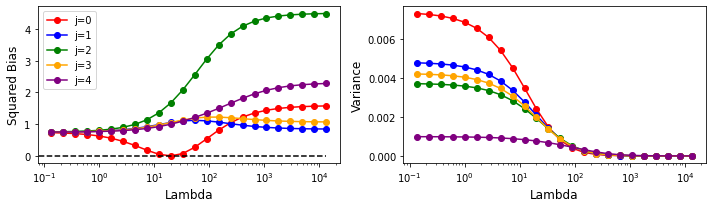

In [7]:
bias_RR = []
var_RR = []

for lamb in lamb_range:
    XTX = X.T@X
    XTX_lambI_inv = np.linalg.inv(XTX + lamb*np.eye(X.shape[1]))
    var_curr = 0.25*XTX_lambI_inv@XTX@XTX_lambI_inv
    bias_curr = np.dot((XTX_lambI_inv@XTX - np.eye(X.shape[1])), beta_star)
    var_RR.append(np.diag(var_curr))
    bias_RR.append(bias_curr)

bias_RR = np.array(bias_RR)
var_RR = np.array(var_RR)
fig, axs = plt.subplots(1, 2, figsize=(10,3))
axs = axs.flatten()
for j in range(RR_solutions.shape[1]):
    axs[0].plot(lamb_range, bias_RR[:, j]**2, color=colors[j], marker='o', label=f'j={j}')
    axs[1].plot(lamb_range, var_RR[:, j], color=colors[j], marker='o', label=f'j={j}')

axs[0].hlines(0, 0, np.max(lamb_range), color="black", linestyle='--')
axs[0].set_xlabel("Lambda", fontsize=12)
axs[0].set_ylabel("Squared Bias", fontsize=12)
axs[0].legend()
axs[0].set_xscale('log')

axs[1].set_xlabel("Lambda", fontsize=12)
axs[1].set_ylabel("Variance", fontsize=12)
axs[1].set_xscale('log')
plt.tight_layout()
plt.show()

These plots indeed confirm our suspicion: for large $\lambda$, the squared bias eventually becomes large (as the coefficients are forced to zero), while the variance becomes smaller. However, this still leaves the question of how to select $\lambda$ in a practical setting, when we don't know $\boldsymbol{\beta}_\star$. In practice, the selection of $\lambda$ is typically done using a hold-out set of data, or a technique called cross-validation. This will be explored in an upcoming homework assignment.

/* ## The LASSO

LASSO regression looks very similar to Ridge Regression at first glance; the solution $\hat{\boldsymbol{\beta}}_{LASSO}(\lambda)$ is given by

$$
\hat{\boldsymbol{\beta}}_{LASSO}(\lambda) = \arg\min_{\boldsymbol{\beta}} \|\boldsymbol{X\beta} - \boldsymbol{y}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_1
$$

The primary difference from Ridge is that we have replaced the penalty term with the 1-norm $\|\boldsymbol{\beta}\|_1$.  */